In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from scipy import signal
from scipy.fft import fft, fftfreq

In [2]:
# Suppress all warnings
warnings.filterwarnings("ignore")

### Helper functions for submitting a submission file for evaluation on the Leaderboard and plotting stock data

In [3]:
def save_predictions(predictions, df_test, output_file_path):
    """
    Saves predictions to a CSV file in the working directory.

    Args:
    - predictions (array-like): Predicted values.
    - df_test (DataFrame): DataFrame containing 'Id' column.
    - output_file_path (str): Path to save the output CSV file.
    """
    output = pd.DataFrame({'Id': df_test['Id'], 'Target': predictions})
    output.to_csv(output_file_path, index=False)

In [4]:
def plot_stock_data(stock_data, features, stock_name, seasonal_dates=None):
    '''
    Function to create a line plot for a single stock.

    Parameters:
        - stock_data (DataFrame): DataFrame containing stock data, with 'Date' as index.
        - features (list of str): List of features to plot on the y-axis.
        - stock_name (str): Name of the stock.
        - seasonal_dates (list of str): List of dates to highlight on the plot.

    Returns:
        - None (displays the plot).
    '''
    # Set figure size
    plt.figure(figsize=(20, 10))
    
    # Plot each feature
    for feature in features:
        plt.plot(stock_data['Date'], stock_data[feature], label=feature)
        
    ax = plt.gca()
    
    if(len(stock_data)>1000):
        # Set x-axis ticks to display every 2 months
        ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=2))
    else:
        # Set x-axis ticks to display 7 days
        ax.get_xaxis().set_major_locator(mdates.DayLocator(interval=7))
    plt.xticks(rotation=45)
    
    # Add legend
    plt.legend()
    
    # Determine date range considering available data
    min_date = stock_data.loc[stock_data['Open'].notnull(), 'Date'].min()
    max_date = stock_data.loc[stock_data['Open'].notnull(), 'Date'].max()
    
    date_range = f"{min_date} to {max_date}"
      
    if seasonal_dates:
        start_date = min(seasonal_dates)
        end_date = max(seasonal_dates)
        plt.axvspan(start_date, end_date, color='orange', alpha=0.3) 
    
    # Add title
    plt.title(f"Stock Data for {stock_name} ({date_range})")
    # Show plot
    plt.tight_layout()
    plt.show()


### Collection of initial data

In [5]:
# File path
file_path = "/kaggle/input/dapprojekt24-1/"

# Load training and test datasets
df_train = pd.read_csv(f"{file_path}train.csv")
df_test = pd.read_csv(f"{file_path}test.csv")

### Feature engineering

In [6]:
# Drop rows with missing values in specific columns
df_train = df_train.dropna(subset=['Adj Close', 'Close', 'High', 'Low', 'Open'])

# Identifying rows where the symbol is 'MMM' and interpolating missing values in the 'Volume' column
mask_MMM = df_train['Symbol'] == 'MMM'
df_train.loc[mask_MMM, 'Volume'] = df_train.loc[mask_MMM, 'Volume'].interpolate(method='spline', order=3)

# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Replace negative values with NaN
df_train.loc[df_train['High'] < 0, 'High'] = float('nan')

# Apply KNNImputer on 'High' column for 'BALL' symbol
df_train.loc[df_train['Symbol'] == 'BALL', 'High'] = imputer.fit_transform(df_train.loc[df_train['Symbol'] == 'BALL', ['High']])

# Group data by 'Symbol'
grouped_test_data = df_test.groupby('Symbol')

# Iterate over groups
for symbol, group in grouped_test_data:
    # Select features for imputation
    features_to_impute = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    
    # Impute missing values for the current group
    imputed_values = imputer.fit_transform(group[features_to_impute])
    
    # Replace NaN values in the group with imputed values
    group[features_to_impute] = imputed_values
    
    # Update the original DataFrame with the imputed values
    df_test.loc[group.index, features_to_impute] = imputed_values

# Check if there are any missing values after imputation
if df_test.isna().sum().sum() == 0:
    print("Missing values have been successfully imputed.")
else:
    print("There are still missing values in the dataset.")

Missing values have been successfully imputed.


In [7]:
def encode_symbols(df):
    """
    Encode stock symbols into integer codes using LabelEncoder.

    Parameters:
    df (DataFrame): DataFrame containing stock information with a column 'Symbol'.

    Returns:
    DataFrame: DataFrame with an additional column 'Symbol_Code' containing encoded integer values.
    """
    # Create a new LabelEncoder object
    label_encoder = LabelEncoder()
    
    # Apply encoding to the 'Symbol' column and add the result to a new column 'Symbol_Code'
    df['Symbol_Code'] = label_encoder.fit_transform(df['Symbol'])
    
    # Return DataFrame with the added encoded column
    return df

def add_date_features(df, date_column):
    """
    Adds date-related features to a dataframe.

    Parameters:
    df (DataFrame): DataFrame to which the date features will be added.
    date_column (str): The name of the column in df that contains date information.

    Returns:
    DataFrame: The original DataFrame with added date features.
    """
    # Ensure the date column is of type datetime
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Extract date features
    df['year'] = df[date_column].dt.year
    df['month'] = df[date_column].dt.month
    df['day'] = df[date_column].dt.day
    df['dayOfWeekName'] = df[date_column].dt.day_name()
    df['dayOfWeekCode'] = pd.Categorical(df[date_column].dt.day_name(), categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).codes
    df['isWorkday'] = df[date_column].dt.dayofweek < 5  # Monday=0, Sunday=6

    return df

In [8]:
#  Encoding non numeric features
df_train = encode_symbols(df_train)
df_test = encode_symbols(df_test)

#  Adding date-related features
df_train = add_date_features(df_train, 'Date')
df_test = add_date_features(df_test, 'Date')

# Data preparation

In [9]:
def find_seasonal_stocks(df):
    """
    Identifies stocks with significant seasonal components from a given dataframe.

    This function takes a dataframe containing stock data, performs STL decomposition
    on the adjusted closing prices of each stock, and identifies stocks with significant
    seasonal components based on the variance of the seasonal component.

    Parameters:
    df : A dataframe with stock data.

    Returns:
    tuple: A tuple containing three elements:
        - seasonal_stocks (list): A list of stock symbols that have significant seasonal components.
        - results (list): A list of STL decomposition results for each identified seasonal stock.
        - seasonal_periods (dict): A dictionary where keys are stock symbols and values are the lengths of their seasonal components.
    """
    seasonal_stocks = []
    results = []
    seasonal_periods = {}
    # Get the unique stock symbols from the dataframe
    symbols = df['Symbol'].unique()
    
    for symbol in symbols:
         # Filter the dataframe to get data for the current symbol
        stock_data = df[df['Symbol'] == symbol].set_index('Date')['Adj Close']
        stock_data.index = pd.to_datetime(stock_data.index)
        # Ensure the data has a daily frequency and interpolate missing values
        stock_data = stock_data.asfreq('D').interpolate()
        
        # Apply STL decomposition to the stock data with a seasonal period of 91 days
        stl = STL(stock_data, seasonal=91)
        result = stl.fit()
        
        # Check if the variance of the seasonal component exceeds the threshold (0.4)
        seasonal_component = result.seasonal
        if np.var(seasonal_component) > 0.4:  
            seasonal_stocks.append(symbol)
            results.append(result)
            seasonal_periods[symbol] = len(seasonal_component)
    
    return seasonal_stocks,results,seasonal_periods

In [10]:
seasonal_stocks, seasonal_stocks_fit,seasonal_periods = find_seasonal_stocks(df_train)
print("Stock with seasonality:", seasonal_stocks)

Stock with seasonality: ['NVR']


We are now focusing on **NVR** stock.

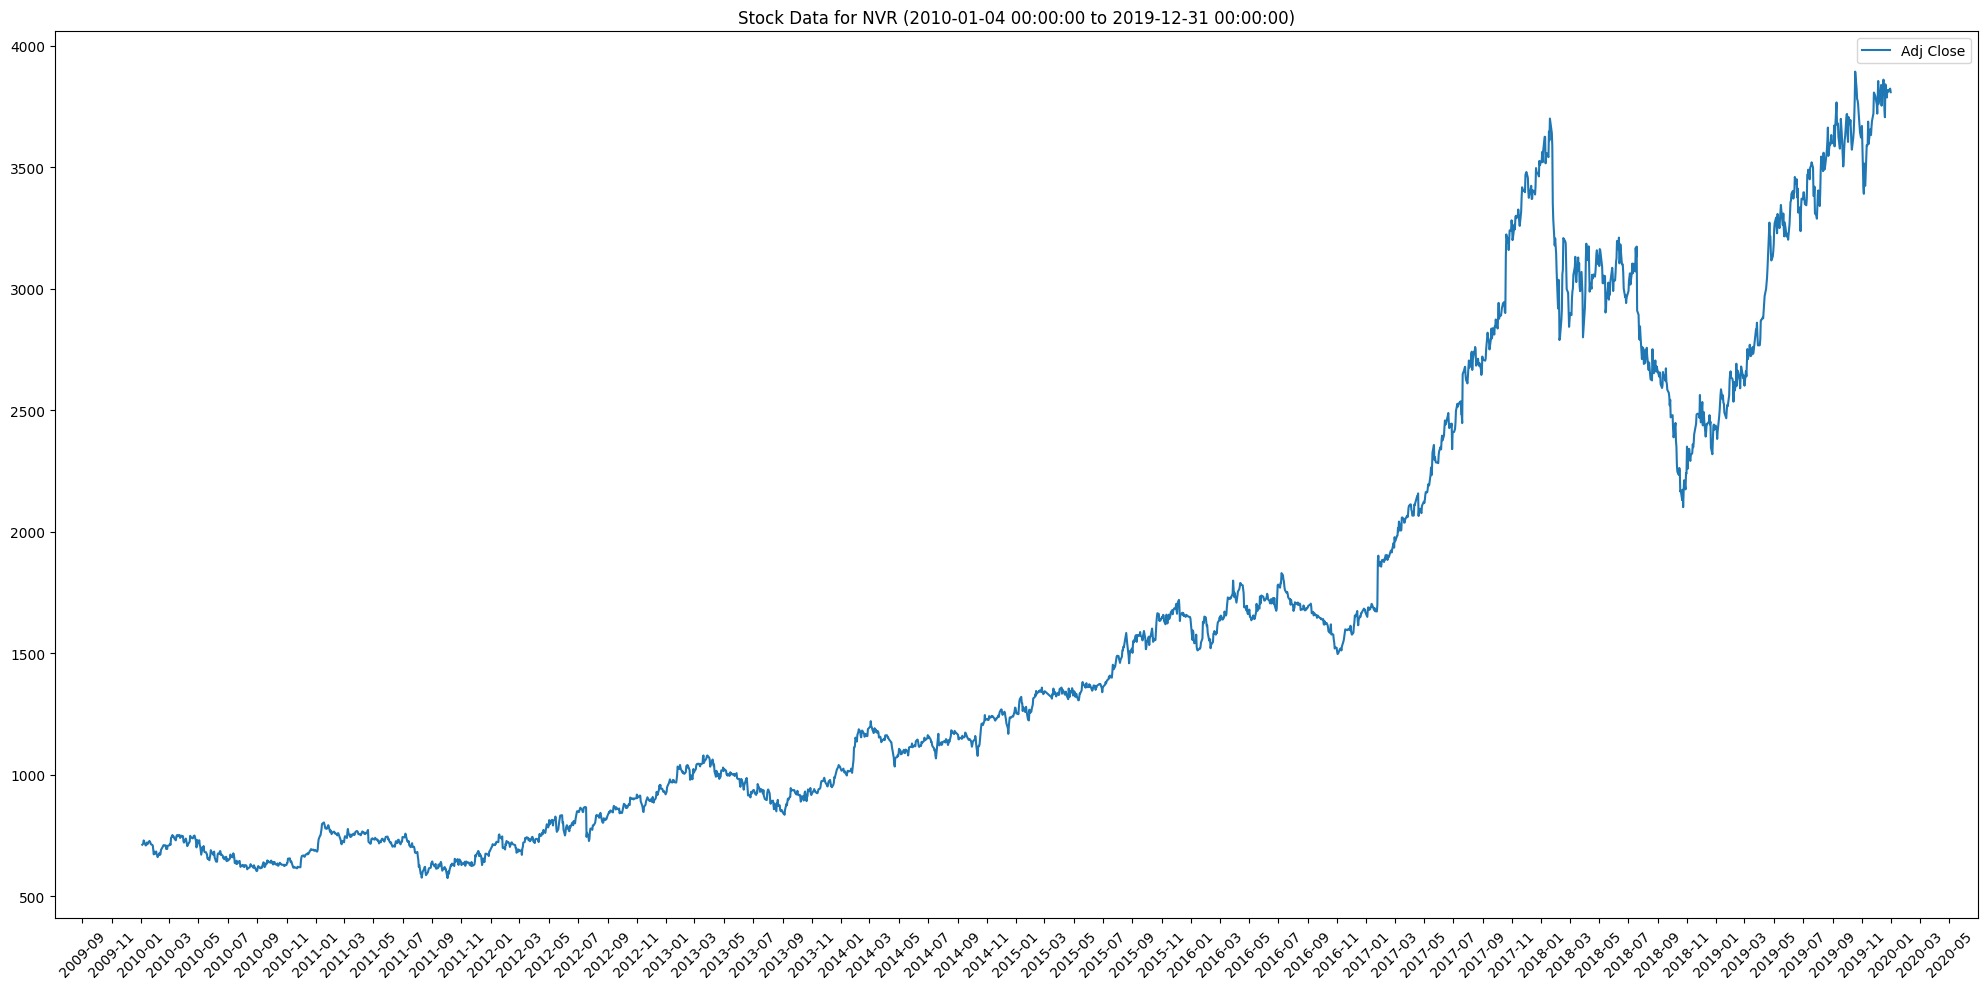

In [11]:
stock_with_seasonality = seasonal_stocks[0]

plot_stock_data(stock_data=df_train[df_train['Symbol'] == stock_with_seasonality], 
                    features=['Adj Close'], 
                    stock_name=stock_with_seasonality)

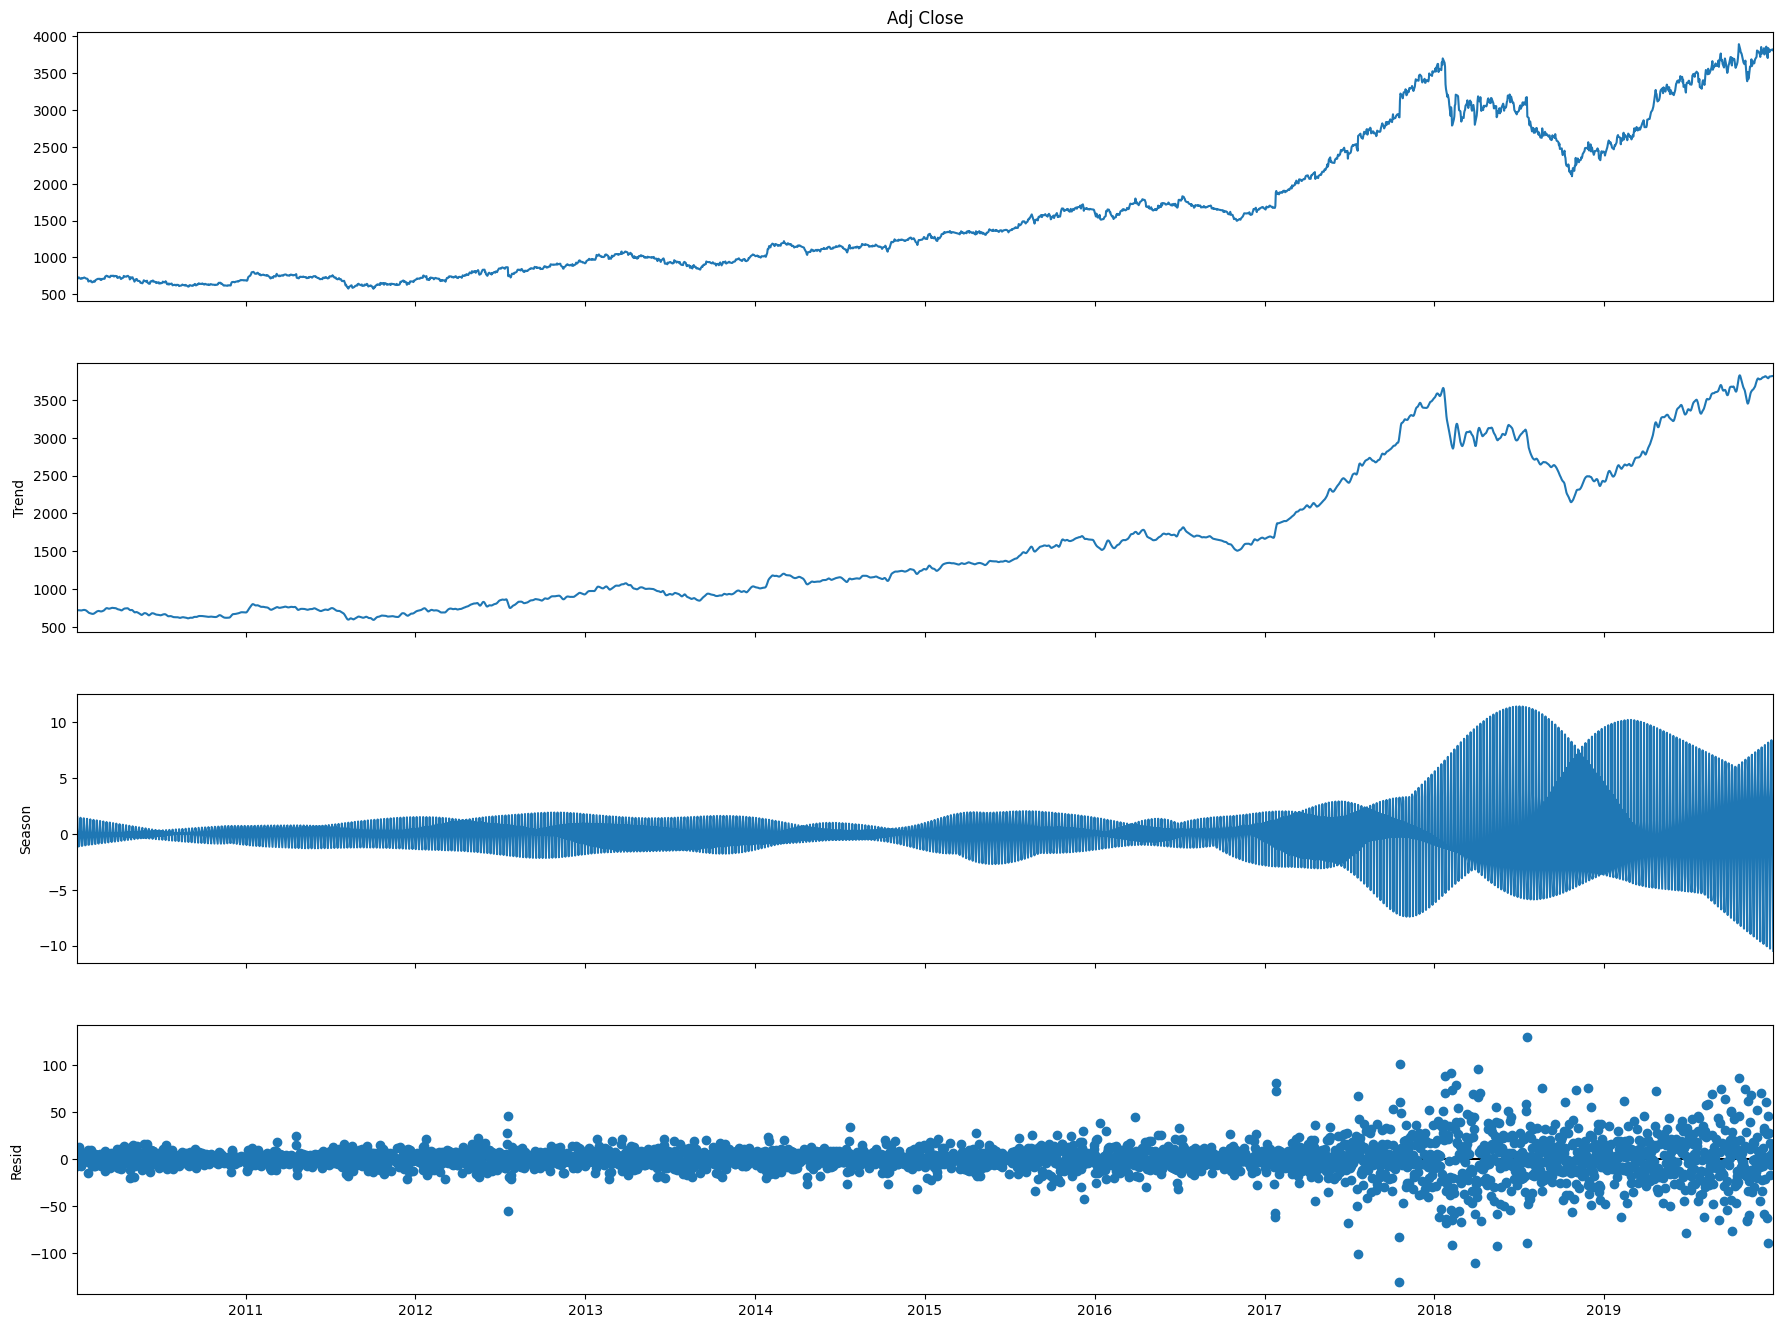

In [12]:
result = seasonal_stocks_fit[0]

fig = result.plot()
fig.set_size_inches(20, 15)  
plt.show()

The STL (Seasonal-Trend decomposition using Loess) decomposition splits the time series into three components: Trend, Seasonal, and Residual.

1. Trend: 
    * The trend component for this stock shows a steady increase over the years, with some noticeable fluctuations.
    * The stock value has a general upward trend with some periods of plateau and rapid growth.
2. Seasonal:
    * This periodicity indicates regular fluctuations in the stock value that occur within a specific interval 
    * There is a clear shift from small, regular oscillations to larger, more irregular ones over time.
    * This suggests a dynamic seasonal pattern where the seasonal effects on the stock prices have evolved. 
3. Residual:
    * The spread of the residuals appears consistent, with some periods showing more significant deviation from zero, indicating higher volatility or unexpected events during those times.

# Exponential smoothing

In [13]:
# Filter the dataset to include only the adjusted close prices for the stock with seasonality
stock_data = df_train[df_train['Symbol'] == stock_with_seasonality]['Adj Close']

# Split the stock data into training and test sets, using 70% for training and 30% for testing
# Ensure the data is not shuffled to maintain the time series order
train_data, test_data = train_test_split(stock_data, test_size=0.3, shuffle=False)

# Apply the Exponential Smoothing model on the training data with a seasonal period of 12
model = ExponentialSmoothing(train_data, seasonal_periods=91).fit()

# Forecast the values for the test set period
forecast = model.forecast(len(test_data))

# Calculate the Root Mean Square Error (RMSE) between the test data and the forecasted values
rmse = np.sqrt(mean_squared_error(test_data, forecast))

# Calculate the Mean Absolute Error (MAE) between the test data and the forecasted values
mae = mean_absolute_error(test_data, forecast)

# Print the RMSE and MAE values
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 1343.120776883855
MAE: 1230.7728129486431


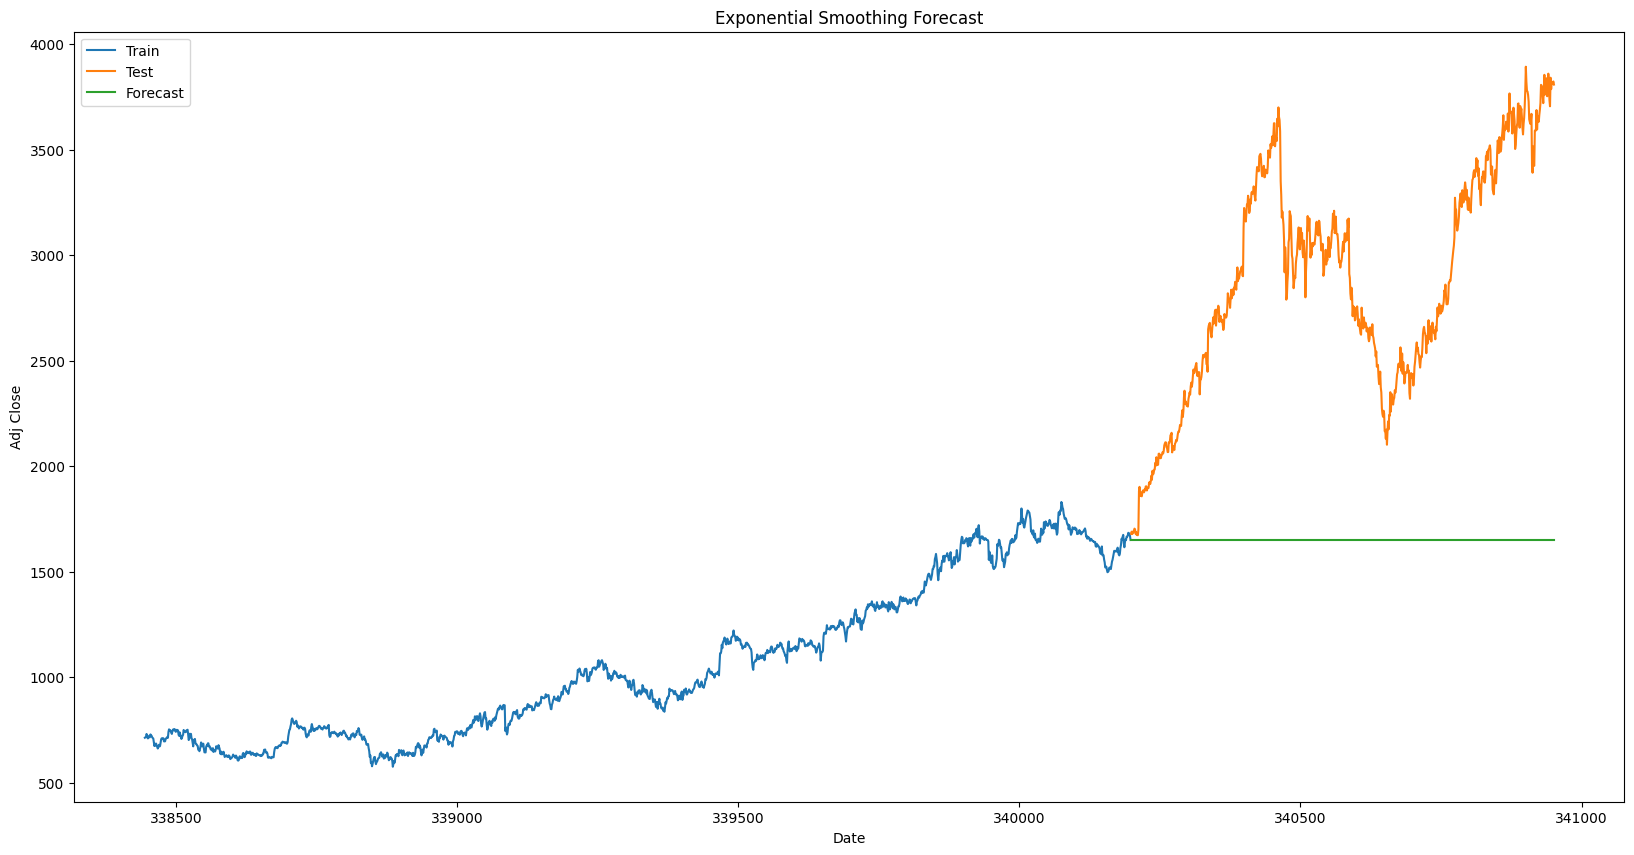

In [14]:
plt.figure(figsize=(20, 10))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(test_data.index, forecast, label='Forecast')
plt.title(f'Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.show()

Based on the results shown in the graph, it appears that the forecasted values are constant, forming a flat line. This indicates that the model is not capturing the underlying patterns in the data effectively.
Here are the key points to conclude why the predictions are constant:
* Model Configuration
* Lack of Trend and Seasonality Components
* Model Parameters

In [15]:
def find_best_exponential_smoothing_params(train_data, test_data, param_grid):
    """
    Finds the best parameters for the Exponential Smoothing model using grid search.

    This function performs a grid search over specified parameter values to find the
    best configuration for an Exponential Smoothing model that minimizes the root mean
    squared error (RMSE) on the test dataset.

    Parameters:
    train_data (pandas.Series or numpy.ndarray): The training data for the model.
    test_data (pandas.Series or numpy.ndarray): The test data to evaluate the model.
    param_grid (dict): A dictionary specifying the parameter grid to search over. 

    Returns:
    tuple: A tuple containing four elements:
        - best_params (dict): A dictionary of the best parameters found.
        - best_rmse (float): The RMSE of the model with the best parameters.
        - best_forecast (numpy.ndarray or pandas.Series): The forecasted values from the best model.
        - best_fit (statsmodels.tsa.holtwinters.ExponentialSmoothing): The fitted model with the best parameters.
    """
    best_rmse = float('inf')
    best_params = None
    best_forecast = None
    best_fit = None
    
    for trend, seasonal, seasonal_periods, sl, ss, se in product(
        param_grid['trend'], 
        param_grid['seasonal'], 
        param_grid['seasonal_periods'],
        param_grid['smoothing_level'],
        param_grid['smoothing_slope'],
        param_grid['smoothing_seasonal']
    ):
        try:
            model = ExponentialSmoothing(
                train_data, 
                trend=trend, 
                seasonal=seasonal, 
                seasonal_periods=seasonal_periods
            ).fit(
                smoothing_level=sl,
                smoothing_slope=ss,
                smoothing_seasonal=se
            )
            forecast = model.forecast(len(test_data))
            rmse = np.sqrt(mean_squared_error(test_data, forecast))
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = {
                    'trend': trend, 
                    'seasonal': seasonal, 
                    'seasonal_periods': seasonal_periods,
                    'smoothing_level': sl,
                    'smoothing_slope': ss,
                    'smoothing_seasonal': se
                }
                best_forecast = forecast
                best_fit = model
        except Exception as e:
            continue
    
    return best_params, best_rmse, best_forecast,best_fit

In [16]:
param_grid = {
    'trend': ['add', 'mul'],
    'seasonal': ['add', 'mul'],
    'seasonal_periods': [91,181],  
    'smoothing_level': [0.3,0.5],
    'smoothing_slope': [ 0.03, 0.1],
    'smoothing_seasonal': [0.02, 0.1]
}

best_params, best_rmse, best_forecast, best_fit = find_best_exponential_smoothing_params(train_data, test_data, param_grid)

best_mae = mean_absolute_error(test_data, best_forecast)

print(f'Best parameters: {best_params}')
print(f'Best RMSE: {best_rmse}')
print(f'Best MAE: {best_mae}')

Best parameters: {'trend': 'mul', 'seasonal': 'add', 'seasonal_periods': 91, 'smoothing_level': 0.3, 'smoothing_slope': 0.1, 'smoothing_seasonal': 0.02}
Best RMSE: 653.4210927942831
Best MAE: 540.1210399359858


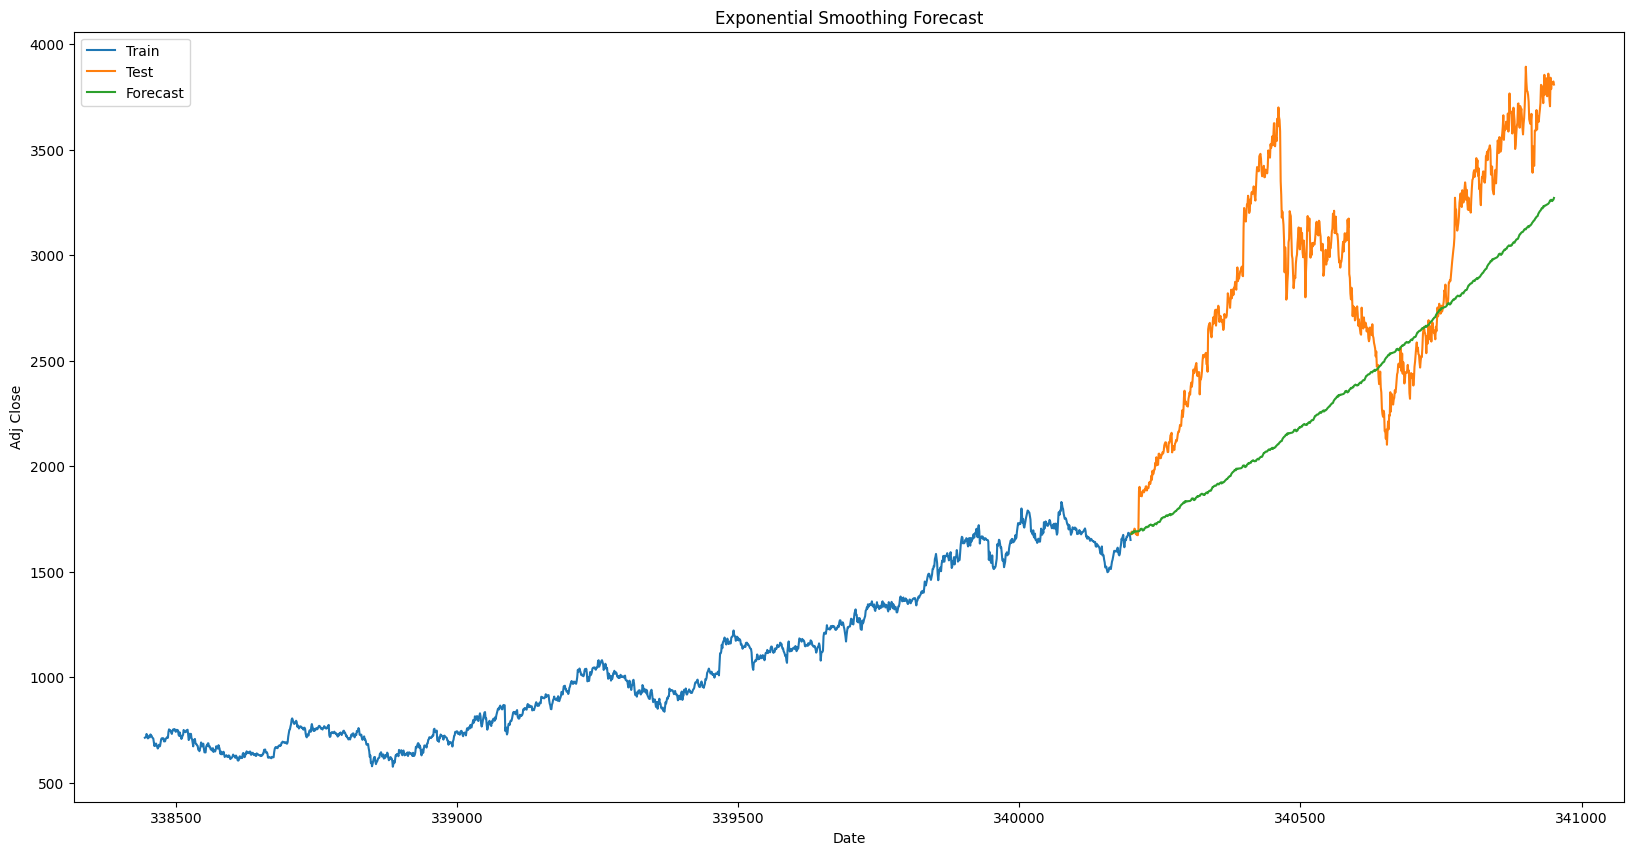

In [17]:
#{'trend': 'mul', 'seasonal': 'add', 'seasonal_periods': 91, 'smoothing_level': 0.3, 'smoothing_slope': 0.1, 'smoothing_seasonal': 0.02}

plt.figure(figsize=(20, 10))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(test_data.index, best_forecast, label='Forecast')
plt.title(f'Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.show()

### Comparison
Comparison with baseline model where p,q and d is 0:
   * RMSE dropped by 689.700 (approximately 51.3% improvement)
   * MAE decreased by 690.652 (approximately 56.1% improvement)

By performing parameter optimization on the Exponential Smoothing model, I managed to considerably improve its accuracy. The optimized model demonstrates a much better fit to the data, as evidenced by the substantial reductions in both RMSE and MAE.

# ARIMA

### Base model

RMSE: 1902.5177779870626
MAE: 1824.9389555141995


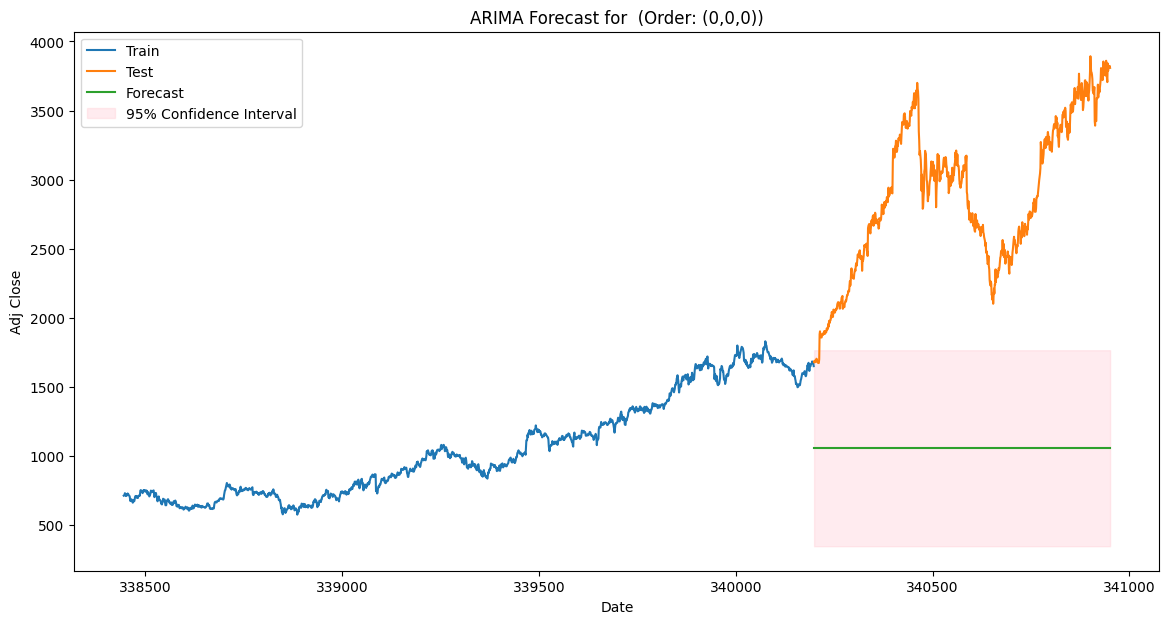

In [18]:
# Apply ARIMA model with parameters (0,0,0) white noise
model = ARIMA(train_data, order=(0, 0, 0))
model_fit = model.fit()

# Forecast values for the test set
forecast = model_fit.forecast(steps=len(test_data), alpha=0.05)
forecast_index = test_data.index

# Calculate the confidence interval
forecast_ci = model_fit.get_forecast(steps=len(test_data)).conf_int(alpha=0.05)

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mae = mean_absolute_error(test_data, forecast)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(forecast_index, forecast, label='Forecast')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title(f'ARIMA Forecast for  (Order: (0,0,0))')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.show()

The width of the confidence interval suggests the level of uncertainty in our predictions. A wider interval indicates higher uncertainty, while a narrower interval suggests more confidence in the predicted values. In the context of stock price prediction, a wide confidence interval implies that the model's predictions are less reliable, while a narrow confidence interval indicates higher confidence in the predicted values.

Regarding the obtained predictions, if the prediction is a constant value and the lower and upper bounds of the confidence interval are also constant, it suggests that the model is not capturing the underlying patterns or variability in the data effectively.

In [19]:
def plot_results(train, test, forecast, title):
    plt.figure(figsize=(14, 7))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Adj Close')
    plt.legend()
    plt.show()

def evaluate_arima_model(train, test, arima_order):
    """
    Evaluates an ARIMA model for given order parameters on train and test datasets.

    This function fits an ARIMA model to the training data using the specified order
    parameters, then forecasts the test data and calculates the root mean squared error (RMSE)
    and mean absolute error (MAE) of the forecast.

    Parameters:
    train (pandas.Series or numpy.ndarray): The training data for the model.
    test (pandas.Series or numpy.ndarray): The test data to evaluate the model.
    arima_order (tuple): A tuple specifying the order of the ARIMA model.
                         If the tuple has 3 elements, it's treated as (p, d, q).
                         If the tuple has 4 elements, it's treated as (p, d, q, s) for seasonal ARIMA.

    Returns:
    tuple: A tuple containing four elements:
        - rmse (float): The root mean squared error of the forecast.
        - mae (float): The mean absolute error of the forecast.
        - forecast (numpy.ndarray or pandas.Series): The forecasted values from the model.
        - model_fit (statsmodels.tsa.arima.model.ARIMAResults): The fitted ARIMA model.
    """
    if len(arima_order) == 3:
        model = ARIMA(train, order=arima_order)
    elif len(arima_order) == 4:
        model = ARIMA(train, seasonal_order=arima_order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    return rmse, mae, forecast, model_fit

def arima_grid_search(train, test, p_values, d_values, q_values, s_values=None):
    """
    Performs a grid search to find the best ARIMA model parameters.

    This function iterates over combinations of ARIMA parameters (p, d, q) and optionally
    seasonal parameters (s), evaluates each model, and finds the configuration that minimizes
    the root mean squared error (RMSE) on the test dataset.

    Parameters:
    train (pandas.Series or numpy.ndarray): The training data for the model.
    test (pandas.Series or numpy.ndarray): The test data to evaluate the model.
    p_values (list): List of ARIMA p parameters to try.
    d_values (list): List of ARIMA d parameters to try.
    q_values (list): List of ARIMA q parameters to try.
    s_values (list, optional): List of seasonal s parameters to try.

    Returns:
    tuple: A tuple containing four elements:
        - results_df (pandas.DataFrame): A dataframe with the ARIMA orders and their corresponding RMSE and MAE.
        - best_cfg (tuple): The best ARIMA configuration found.
        - best_forecast (numpy.ndarray or pandas.Series): The forecasted values from the best model.
        - best_fit (statsmodels.tsa.arima.model.ARIMAResults): The fitted ARIMA model with the best parameters.
    """
    best_score, best_cfg = float("inf"), None
    best_forecast, best_fit = None, None
    results = []
    
    # Iterate over combinations of p, d, q
    for p, d, q in product(p_values, d_values, q_values):
        order = (p, d, q)
        try:
            rmse, mae, forecast, model_fit = evaluate_arima_model(train, test, order)
            results.append((order, rmse, mae))
            if rmse < best_score:
                best_score, best_cfg = rmse, order
                best_forecast, best_fit = forecast, model_fit
            #print(f"ARIMA{order} RMSE={rmse:.3f} MAE={mae:.3f}")
        except Exception as e:
            print(f"ARIMA{order} failed: {e}")
            continue

    # Try seasonal parameter s if provided
    if s_values is not None:
        for s in s_values:
            seasonal_order = (best_cfg[0], best_cfg[1], best_cfg[2], s)
            try:
                model = ARIMA(train, order=best_cfg, seasonal_order=seasonal_order)
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=len(test))
                rmse = np.sqrt(mean_squared_error(test, forecast))
                mae = mean_absolute_error(test, forecast)
                results.append((seasonal_order, rmse, mae))
                if rmse < best_score:
                    best_score, best_cfg = rmse, seasonal_order
                    best_forecast, best_fit = forecast, model_fit
                #print(f"ARIMA{seasonal_order} RMSE={rmse:.3f} MAE={mae:.3f}")
            except Exception as e:
                print(f"ARIMA{seasonal_order} failed: {e}")
                continue

    # Convert results to DataFrame 
    results_df = pd.DataFrame(results, columns=['Order', 'RMSE', 'MAE'])
    return results_df, best_cfg, best_forecast, best_fit

In [20]:
# Define parameter ranges
p_values = [0,1,2,3,4]
d_values = [0,1,2,3,4]
q_values = [0,1,2,3,4]
s_values = [4, 12]  

# Perform ARIMA grid search
results_df, best_cfg, best_forecast, best_fit = arima_grid_search(train_data, test_data, p_values, d_values, q_values, s_values)

# Print the table of parameters used and errors obtained
print("table of the parameters")
print(results_df)

ARIMA(4, 3, 3, 4) failed: Invalid model: autoregressive lag(s) {4} are in both the seasonal and non-seasonal autoregressive components.
table of the parameters
             Order          RMSE           MAE
0        (0, 0, 0)  1.902518e+03  1.824939e+03
1        (0, 0, 1)  1.902400e+03  1.824535e+03
2        (0, 0, 2)  1.902293e+03  1.824046e+03
3        (0, 0, 3)  1.902388e+03  1.824461e+03
4        (0, 0, 4)  1.902238e+03  1.823743e+03
..             ...           ...           ...
121      (4, 4, 1)  8.448822e+05  6.271689e+05
122      (4, 4, 2)  3.192738e+04  2.283623e+04
123      (4, 4, 3)  3.707018e+06  2.505431e+06
124      (4, 4, 4)  7.912104e+05  5.344136e+05
125  (4, 3, 3, 12)  2.930523e+03  2.880763e+03

[126 rows x 3 columns]


### p parameter

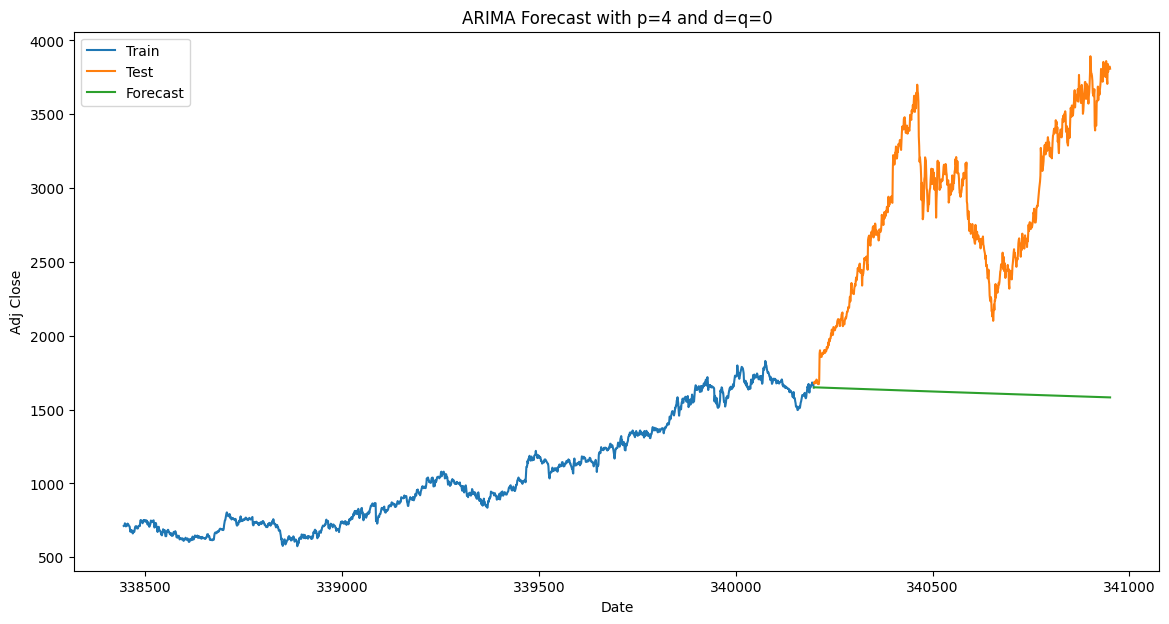

RMSE=1379.204 MAE=1264.369


In [21]:
# Plot results for least error when p is set and others are 0
p_only_results = results_df[results_df['Order'].apply(lambda x: x[1] == 0 and x[2] == 0)]
best_p_order = p_only_results.loc[p_only_results['RMSE'].idxmin()]['Order']
rmse, mae, forecast, model_fit = evaluate_arima_model(train_data, test_data, best_p_order)
plot_results(train_data, test_data, forecast, f'ARIMA Forecast with p={best_p_order[0]} and d=q=0')
print(f"RMSE={rmse:.3f} MAE={mae:.3f}")

Setup: p=4, d=0, q=0. The auto-regressive parameter 𝑝 controls the number of lag observations included in the model.

Comparison with baseline model where p,q and d is 0:
   * RMSE reduced by 523.314 (27.5% improvement)
   * MAE reduced by 560.570 (30.7% improvement)
   
The prediction appears to have some fluctuations captured due to the consideration of past observations, but the overall error remains relatively high.


### q parameter

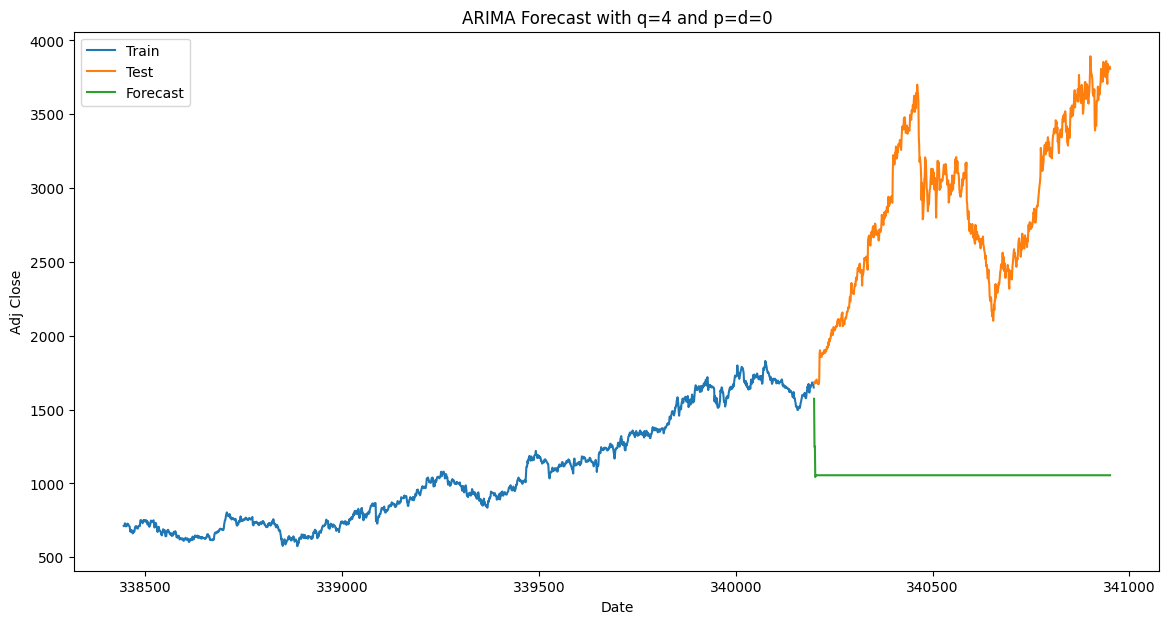

RMSE=1902.238 MAE=1823.743


In [22]:
# Plot results for least error when q is set and others are 0
q_only_results = results_df[results_df['Order'].apply(lambda x: x[0] == 0 and x[1] == 0)]
best_q_order = q_only_results.loc[q_only_results['RMSE'].idxmin()]['Order']
rmse, mae, forecast, model_fit = evaluate_arima_model(train_data, test_data, best_q_order)
plot_results(train_data, test_data, forecast, f'ARIMA Forecast with q={best_q_order[2]} and p=d=0')
print(f"RMSE={rmse:.3f} MAE={mae:.3f}")

Setup: p=0, d=0, q=4. The moving average parameter 𝑞 controls the number of lagged forecast errors in the prediction equation.

Comparison with baseline model where p,q and d is 0:
   * RMSE reduced by 0.279 (0.01% improvement)
   * MAE reduced by 1.196 (0.1% improvement)

The prediction with 𝑞 alone does not significantly improve the model accuracy and results in higher errors compared to other parameter settings.

### d parameter

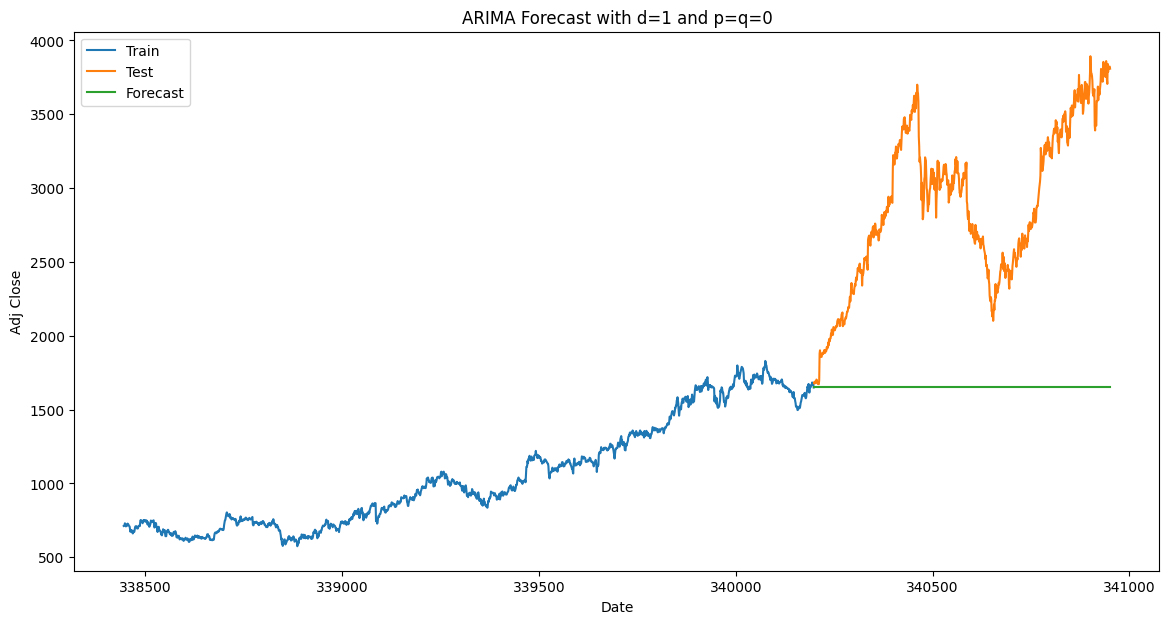

RMSE=1343.121 MAE=1230.773


In [23]:
# Plot results for least error when d is set and others are 0
d_only_results = results_df[results_df['Order'].apply(lambda x: x[0] == 0 and x[2] == 0)]
best_d_order = d_only_results.loc[d_only_results['RMSE'].idxmin()]['Order']
rmse, mae, forecast, model_fit = evaluate_arima_model(train_data, test_data, best_d_order)
plot_results(train_data, test_data, forecast, f'ARIMA Forecast with d={best_d_order[1]} and p=q=0')
print(f"RMSE={rmse:.3f} MAE={mae:.3f}")

Setup: p=0, d=1, q=0. The differencing parameter 𝑑 is used to make the time series stationary by subtracting the previous observation from the current observation

Comparison with baseline model where p,q and d is 0:
   * RMSE reduced by 559.397 (29.4% improvement)
   * MAE reduced by 594.166 (32.5% improvement)
   
The model improves slightly compared to 
𝑝 and 𝑞 alone, indicating some underlying trend or non-stationarity in the data.


### combination of p, d, and q

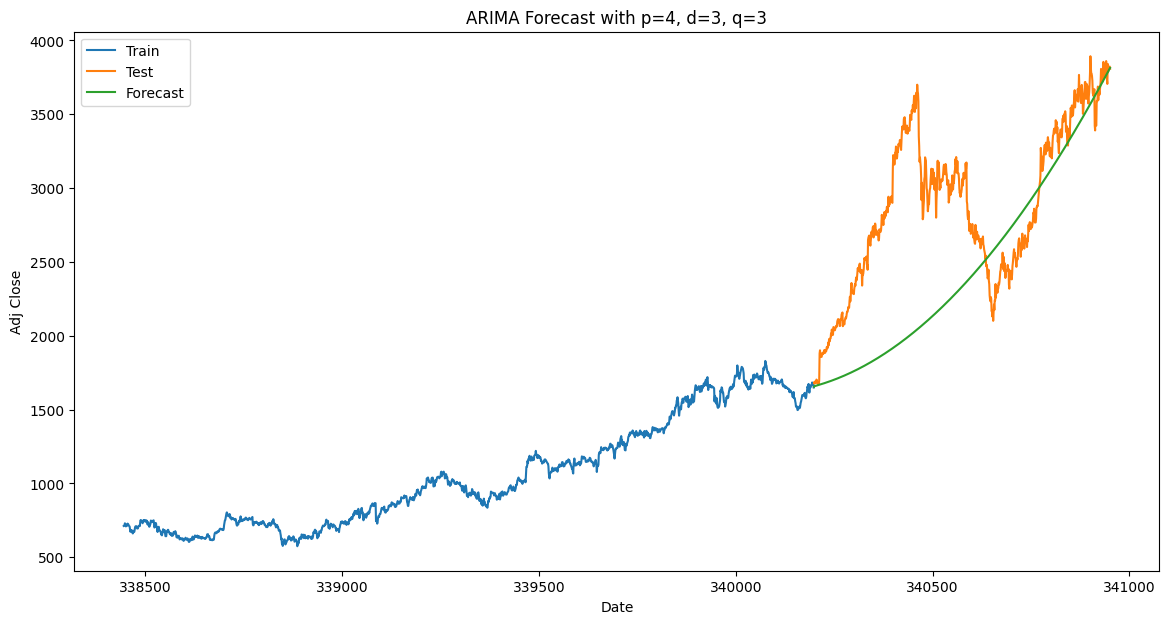

RMSE=651.307 MAE=498.816


In [24]:
# Plot results for least error for combination of p, d, and q
best_non_seasonal_order = results_df.loc[results_df['RMSE'].idxmin()]['Order']
rmse, mae, forecast, model_fit = evaluate_arima_model(train_data, test_data, best_non_seasonal_order)
plot_results(train_data, test_data, forecast, f'ARIMA Forecast with p={best_non_seasonal_order[0]}, d={best_non_seasonal_order[1]}, q={best_non_seasonal_order[2]}')
print(f"RMSE={rmse:.3f} MAE={mae:.3f}")

Setup: p=4, d=3, q=3.

Comparison with baseline model where p,q and d is 0:
   * RMSE reduced by 1251.211 (65.8% improvement)
   * MAE reduced by 1326.123 (72.7% improvement)
   
Combining the parameters provides the model with more flexibility to capture various patterns in the data. This setup significantly reduces the errors, indicating a better fit to the data and capturing more of the underlying structure.

### combination of p, d, q, and s (seasonality)

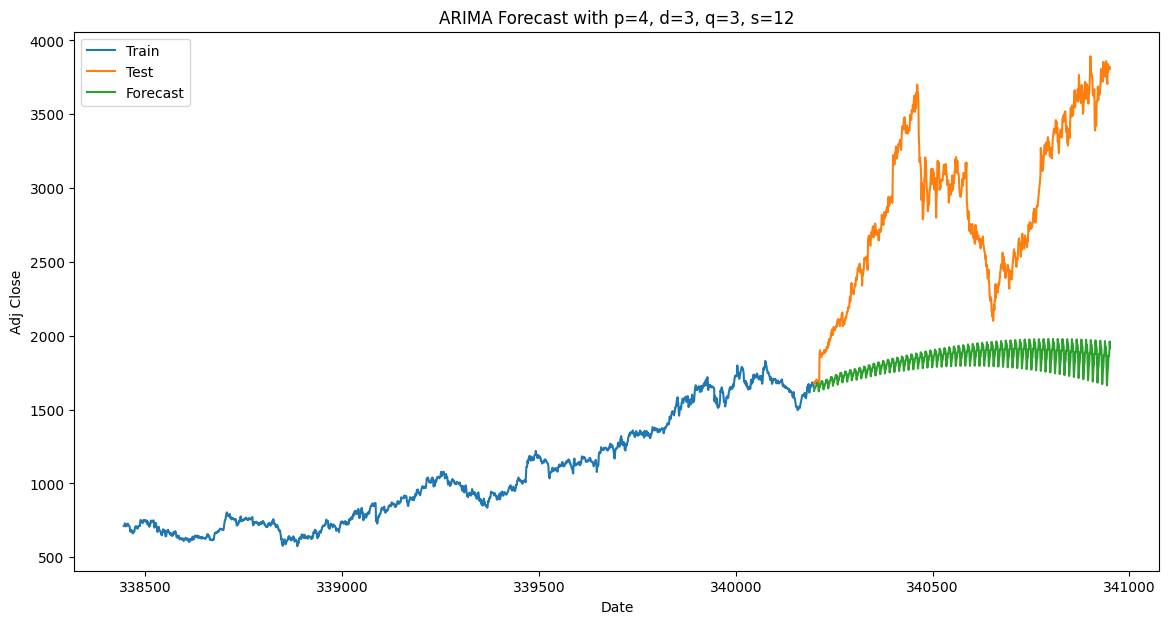

RMSE=1162.480 MAE=1045.945


In [25]:
seasonal_results = results_df[results_df['Order'].apply(lambda x: isinstance(x, tuple) and len(x) == 4)]
if not seasonal_results.empty:
    best_seasonal_order = seasonal_results.loc[seasonal_results['RMSE'].idxmin()]['Order']
    rmse, mae, forecast, model_fit = evaluate_arima_model(train_data, test_data, best_seasonal_order)
    plot_results(train_data, test_data, forecast, f'ARIMA Forecast with p={best_seasonal_order[0]}, d={best_seasonal_order[1]}, q={best_seasonal_order[2]}, s={best_seasonal_order[3]}')
    print(f"RMSE={rmse:.3f} MAE={mae:.3f}")

Setup: p=4, d=3, q=3, s=12.

Comparison with baseline model where p,q and d is 0:
   * RMSE increased by 511.173 (78.5% improvement over the baseline but worse than p, d, q alone)
   * MAE increased by 547.129 (74.3% improvement over the baseline but worse than p, d, q alone)
   
Combining the parameters provides the model with more flexibility to capture various patterns in the data. This setup significantly reduces the errors, indicating a better fit to the data and capturing more of the underlying structure.

Surprisingly, adding seasonality increased the error compared to the best combination of 𝑝, 𝑑 and 𝑞 without seasonality. This suggests that the chosen seasonal period may not align well with the underlying periodic patterns in the data or might indicate overfitting.

### Conclusion
Parameter Impact:
* p: Helps capture dependencies on past values.
* q: Minimal effect alone, slight improvement.
* d: Crucial for handling trends and non-stationarity.
* Combination: Optimal results by capturing various data patterns.
* Seasonality (s): Needs careful tuning; inappropriate seasonal period can worsen the model.

ARIMA models can be useful for short to medium-term forecasting, especially for time series data that exhibits some level of stationarity after differencing. However, forecasting three years into the future using an ARIMA model can be challenging and might not always yield accurate results, especially if the time series data has strong seasonal patterns or trends that extend beyond the immediate past values captured by the ARIMA components.

# Facebook Prophet

### Colum renaming

In [26]:
# Prepare the data for Prophetdf_train[df_train['Symbol'] == stock_with_seasonality]
df_prophet = df_train[df_train['Symbol'] == stock_with_seasonality][['Date', 'Adj Close']].rename(columns={'Date': 'ds', 'Adj Close': 'y'})

### Training base model

13:01:00 - cmdstanpy - INFO - Chain [1] start processing
13:01:01 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 1198.975658463612
MAE: 1075.5755623490359


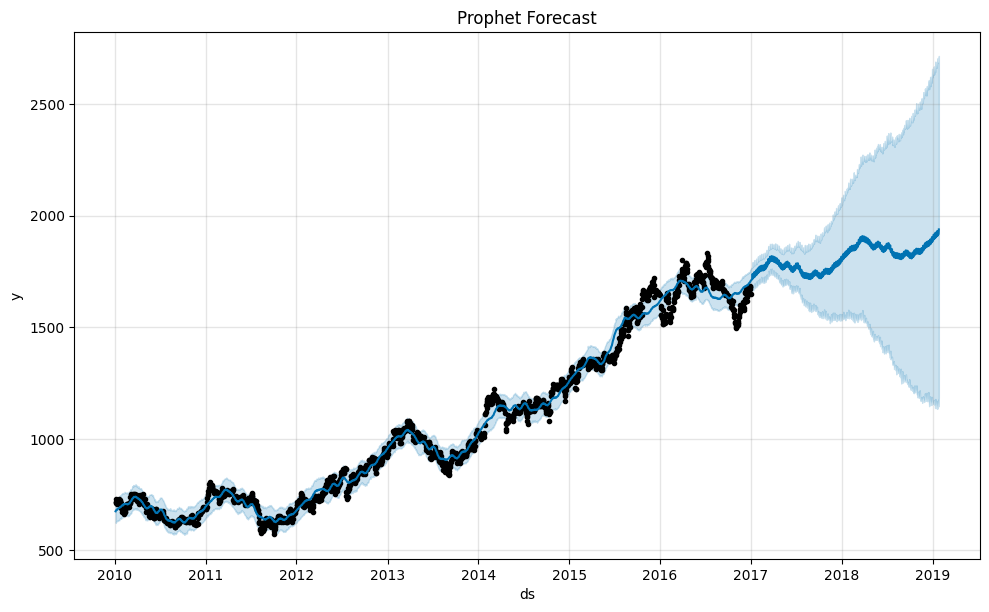

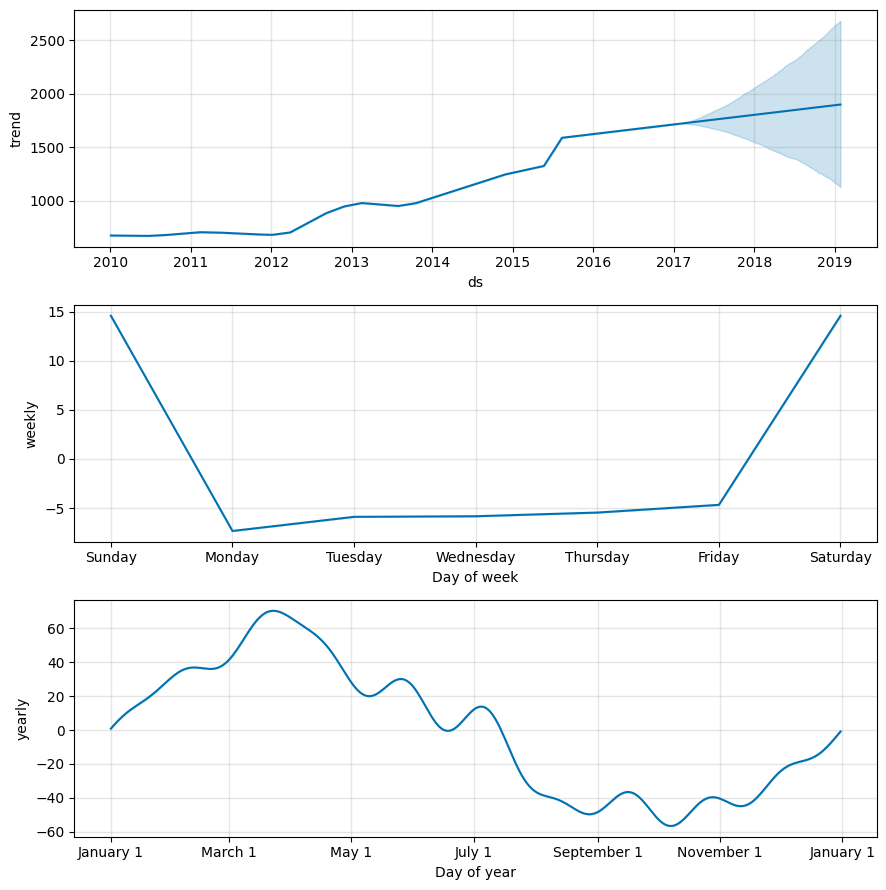

In [27]:
train_data, test_data = train_test_split(df_prophet, test_size=0.3, shuffle=False)
train_size = int(len(df_prophet) * 0.7)

# Train the Prophet model
model = Prophet()
model.fit(train_data)

# Make predictions
future = model.make_future_dataframe(periods=len(test_data), freq='D')  # Ensure daily frequency
forecast = model.predict(future)

# Calculate RMSE and MAE
predictions = forecast['yhat'].iloc[train_size:].reset_index(drop=True)
actuals = test_data['y'].reset_index(drop=True)

rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Plot the forecast
fig1 = model.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

# Plot the forecast components
fig2 = model.plot_components(forecast)
plt.show()

Weekly Seasonality: There is significant seasonality during the week, with pronounced peaks during the weekend

Yearly seasonality: peak in spring (March - May), fall during summer and winter (June - November) and slight increase at the end of the year (December)


### Added seasonality and Fourier order parameter

In [28]:
# Initialize the Prophet model
model = Prophet(yearly_seasonality=True,seasonality_mode='multiplicative',interval_width=0.95)

# Add weekly seasonality
model.add_seasonality(name='weekly', period=7, fourier_order=10)

# Add monthly seasonality
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Add quarterly seasonality
model.add_seasonality(name='quarterly', period=91.25, fourier_order=5)

# Add yearly seasonality
model.add_seasonality(name='yearly', period=365.25, fourier_order=25)

# Define holidays NVR
holidays = pd.DataFrame({
    'holiday': 'market_crash',
    'ds': pd.to_datetime(['2008-01-17','2018-09-20', '2020-02-24', '2022-01-05']),
    'lower_window': 0,
    'upper_window': 1,
})

# Add holidays to the model
model = Prophet(holidays=holidays)
model.add_country_holidays(country_name='US')

13:01:04 - cmdstanpy - INFO - Chain [1] start processing
13:01:05 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 1197.190992013274
MAE: 1073.8398815751807


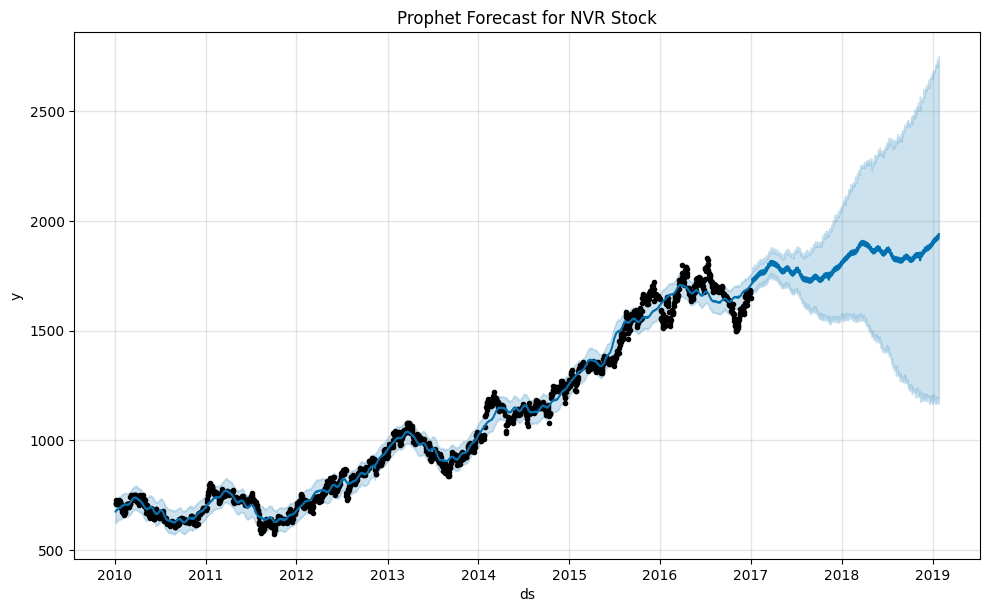

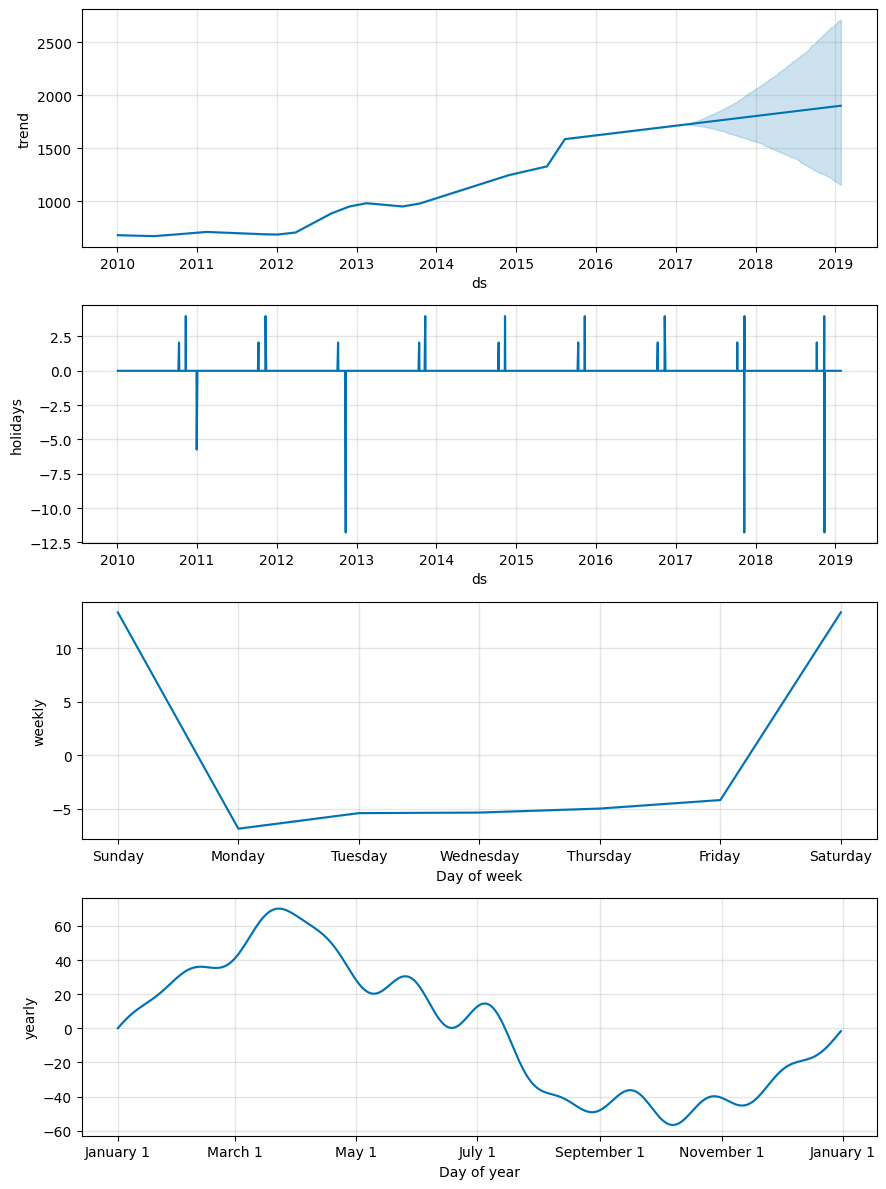

Table of the parameters
  Seasonality  Fourier Order         RMSE          MAE
0      weekly             10  1197.190992  1073.839882
1     monthly              5  1197.190992  1073.839882
2   quarterly              5  1197.190992  1073.839882
3      yearly             20  1197.190992  1073.839882


In [29]:
# Train the Prophet model
model.fit(train_data)

# Make predictions
future = model.make_future_dataframe(periods=len(test_data), freq='D')
forecast = model.predict(future)

# Calculate RMSE and MAE
predictions = forecast['yhat'].iloc[train_size:].reset_index(drop=True)
actuals = test_data['y'].reset_index(drop=True)

rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Plot the forecast
fig1 = model.plot(forecast, uncertainty=True)
plt.title('Prophet Forecast for NVR Stock')
plt.show()

# Plot the forecast components
fig2 = model.plot_components(forecast)
plt.show()

# Display the parameters and errors
params_errors = pd.DataFrame({
    'Seasonality': ['weekly', 'monthly', 'quarterly', 'yearly'],
    'Fourier Order': [10, 5, 5, 20],
    'RMSE': [rmse] * 4,
    'MAE': [mae] * 4
})

print("Table of the parameters")
print(params_errors)

### Comparison

Exponential Smoothing and ARIMA models both show significantly lower RMSE and MAE compared to the Prophet models. Both Exponential Smoothing and ARIMA with optimized parameters achieve RMSE values around 650, which is almost half of the RMSE achieved by the Prophet models.

The adjustments made to the Prophet model by adding seasonality and tuning the Fourier order parameters resulted in a very slight reduction in both RMSE and MAE.

The Prophet algorithm is generally robust for time series data with strong seasonal patterns and trends. However, in this specific case of synthetic data, it appears that the predefined seasonal adjustments did not align well with the underlying patterns in the data.

# RandomForestRegressor

In [30]:
rf_stock_data = df_train[df_train['Symbol'] == stock_with_seasonality]

# Split the stock data into training and test sets, using 70% for training and 30% for testing
train_data, test_data = train_test_split(rf_stock_data, test_size=0.3, shuffle=False)

# Separate features (X) and target (y), removing string type features
X_train = train_data.drop(columns=['Adj Close', 'Date', 'Symbol', 'dayOfWeekName'])
y_train = train_data['Adj Close']
X_test = test_data.drop(columns=['Adj Close', 'Date', 'Symbol', 'dayOfWeekName'])
y_test = test_data['Adj Close']

# Initialize the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict the values for the test set
y_pred = model.predict(X_test)

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 1190.6025337613987
MAE: 1064.8888474390199


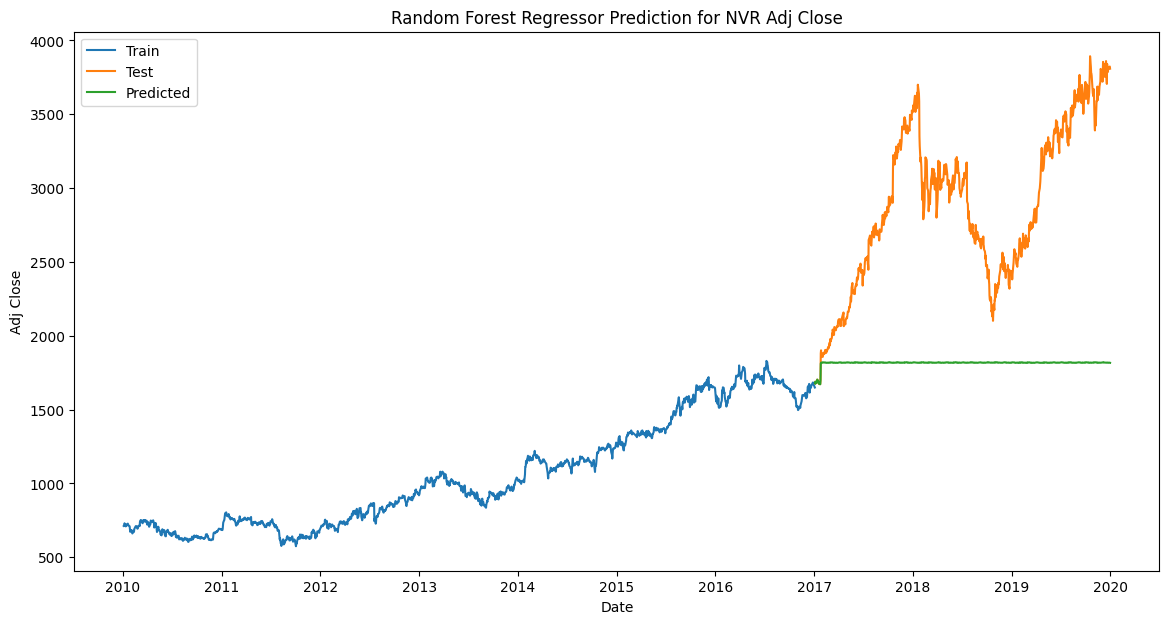

In [31]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train_data['Date'], y_train, label='Train')
plt.plot(test_data['Date'], y_test, label='Test')
plt.plot(test_data['Date'], y_pred, label='Predicted')
plt.title(f'Random Forest Regressor Prediction for {stock_with_seasonality} Adj Close')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.show()

### Comparison
Exponential Smoothing vs. RandomForestRegressor:

 * RMSE: Exponential Smoothing (653.421) significantly outperforms RandomForest (1190.603).
 * MAE: Exponential Smoothing (540.121) significantly outperforms RandomForest (1064.889).

ARIMA vs. RandomForestRegressor:

* RMSE: ARIMA (651.307) significantly outperforms RandomForest (1190.603).
* MAE: ARIMA (498.816) significantly outperforms RandomForest (1064.889).

Prophet vs. RandomForestRegressor:

* RMSE: Prophet (1197.191) is slightly worse than RandomForest (1190.603).
* MAE: Prophet (1073.840) is slightly worse than RandomForest (1064.889).


The RandomForestRegressor baseline model does not perform as well as the optimized Exponential Smoothing and ARIMA models, which show significantly lower RMSE and MAE.

# Generated signal

In [32]:
t = np.linspace(0, 600, 600)
triangle1 = signal.sawtooth(2 * np.pi * 2 * 100 * t) 
triangle2 = signal.sawtooth(2 * np.pi * 2 * 28.57142857 * t, 0.63) 
trend = np.linspace(0, 600, 600)/(165*np.pi)
trend1 = np.linspace(0, 100, 100)/(112*np.pi)
trend2 = np.linspace(0, 300, 300)/(-103*np.pi)
trend3 = np.linspace(0, 200, 200)/(148*np.pi/2)
noise = np.random.normal(0,0.1056,600)
pts = triangle1 + triangle2 + trend + np.concatenate((trend1, trend2, trend3)) + noise

# constants
last_n_rows = 600
n_train_rows = 500

# split
pts_train = pts[:-(last_n_rows-n_train_rows)]
pts_test = pts[-(last_n_rows-n_train_rows):]

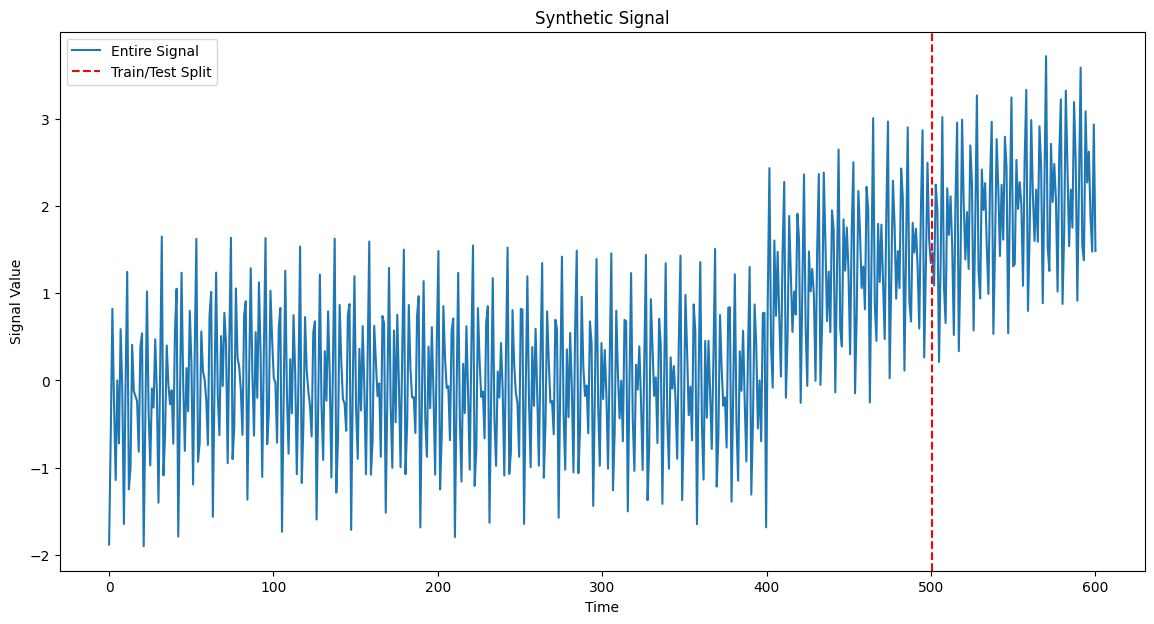

In [33]:
# Plot the entire signal
plt.figure(figsize=(14, 7))
plt.plot(t, pts, label='Entire Signal')
plt.axvline(x=t[n_train_rows], color='r', linestyle='--', label='Train/Test Split')
plt.title('Synthetic Signal')
plt.xlabel('Time')
plt.ylabel('Signal Value')
plt.legend()
plt.show()

The generated signal consists of several components:
1. Triangle Waves:
    * A high-frequency sawtooth wave
    * A lower-frequency sawtooth wave with a duty cycle
2. Trends:
    * Linear trends applied to different segments of the signal
3. Noise:
    * Gaussian noise added to the signal

## Signal periodicity

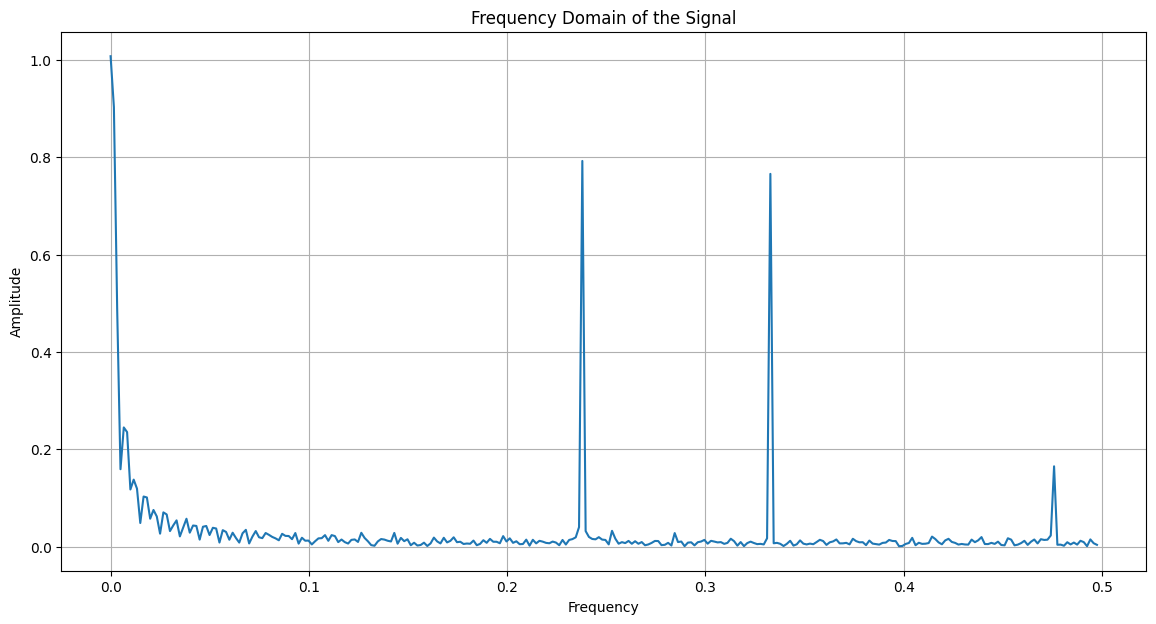

In [34]:
# Perform FFT
N = len(pts)
T = t[1] - t[0]  # Sample spacing
yf = fft(pts)
xf = fftfreq(N, T)[:N // 2]

# Plot the FFT results
plt.figure(figsize=(14, 7))
plt.plot(xf, 2.0 / N * np.abs(yf[:N // 2]))
plt.title('Frequency Domain of the Signal')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

The FFT analysis transforms the time-domain signal into the frequency domain to identify the dominant frequencies.

The FFT plot reveals several prominent peaks:
* First Peak: The first peak occurs at a low frequency, indicating a long-period component in the signal.
* Second Peak: A prominent peak at around 0.2, suggesting another periodic component with a higher frequency.
* Third Peak: Another significant peak at around 0.3, representing another periodic component.

These peaks indicate that the signal has multiple periodic components at different frequencies

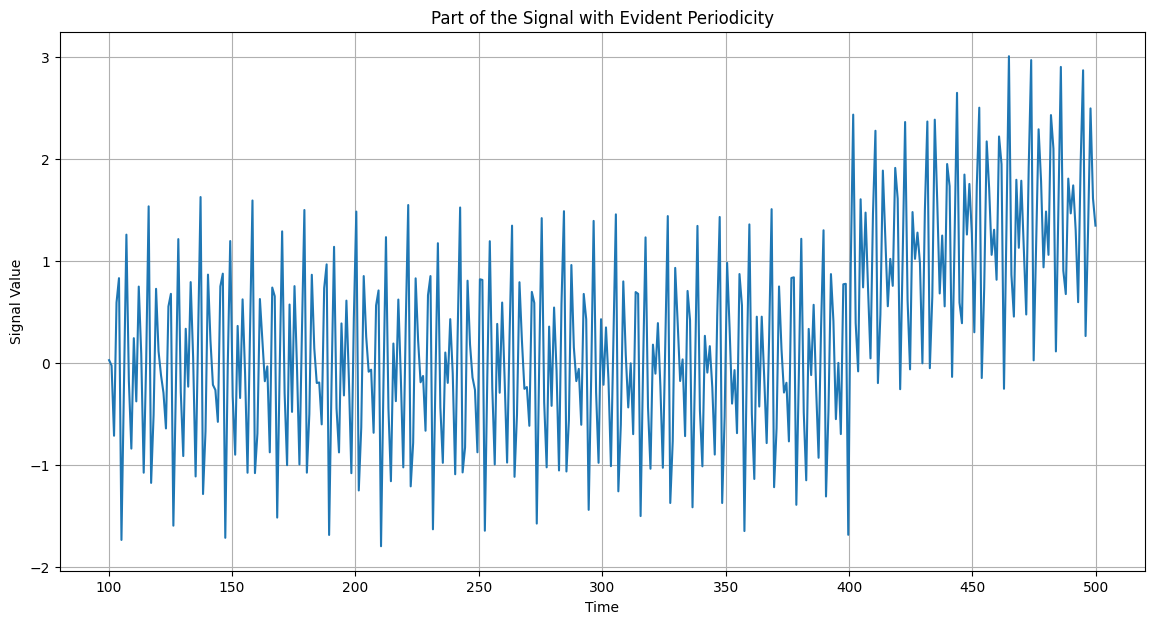

In [35]:
# Visualize a part of the signal where periodicity is evident
period = 1 / (2 * 100)  # Frequency from triangle1
start_index = int(0.5 / period)
end_index = int(2.5 / period)

plt.figure(figsize=(14, 7))
plt.plot(t[start_index:end_index], pts[start_index:end_index])
plt.title('Part of the Signal with Evident Periodicity')
plt.xlabel('Time')
plt.ylabel('Signal Value')
plt.grid()
plt.show()

The visualized segment confirms the presence of periodicity in the synthetic signal. The regular oscillations indicate that the signal has inherent periodic components, which were identified in the frequency domain analysis. The trends and noise added to the signal contribute to the overall complexity, but the underlying periodic nature remains evident in this segment.

## Trend in the signal

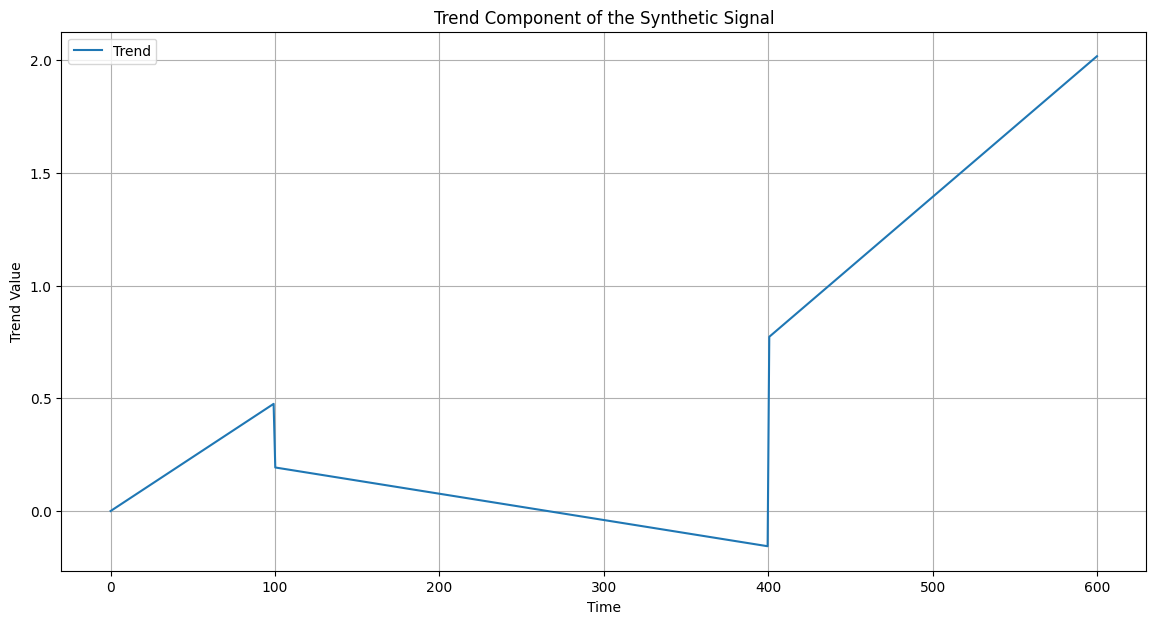

In [36]:
# Concatenate the trends
full_trend = trend + np.concatenate((trend1, trend2, trend3))

# Plot the signal components
plt.figure(figsize=(14, 7))
plt.plot(t, full_trend, label='Trend')
plt.title('Trend Component of the Synthetic Signal')
plt.xlabel('Time')
plt.ylabel('Trend Value')
plt.legend()
plt.grid()
plt.show()

Trend analysis
* Initial Trend (0 to 100 samples): The signal shows an increasing trend with a positive slope. This segment is characterized by a gradual increase in the signal value.
* Middle Trend (100 to 400 samples): The signal exhibits a decreasing trend with a negative slope. The signal value decreases steadily during this period.
* Final Trend (400 to 600 samples): The signal resumes an increasing trend with a positive slope, showing a rapid rise in the signal value towards the end of the series.

In [37]:
# Split the data into training and test sets
train_size = int(len(pts) * 0.7)
train_data, test_data = pts[:train_size], pts[train_size:]

## Exponential Smoothing

Exponential Smoothing - RMSE: 0.9749926608243418, MAE: 0.8058974656362848


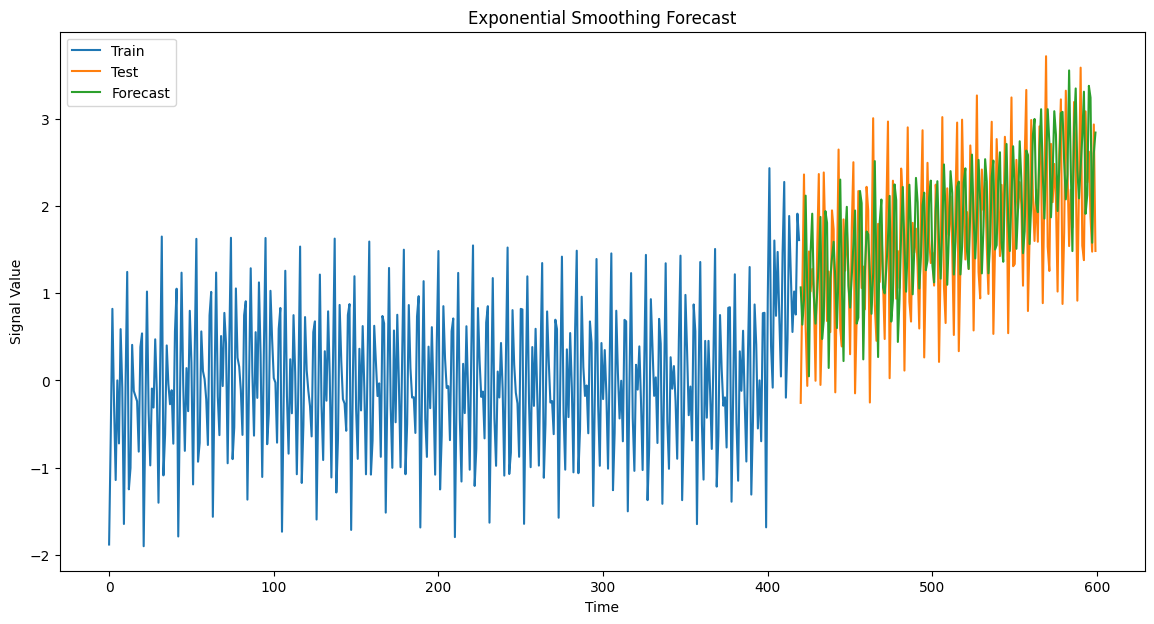

In [38]:
# Apply Exponential Smoothing
model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=160).fit(smoothing_level=0.3, smoothing_slope= 0.01, smoothing_seasonal= 0.02)
forecast = model.forecast(len(test_data))

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mae = mean_absolute_error(test_data, forecast)
print(f'Exponential Smoothing - RMSE: {rmse}, MAE: {mae}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(range(len(train_data)), train_data, label='Train')
plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test')
plt.plot(range(len(train_data), len(train_data) + len(test_data)), forecast, label='Forecast')
plt.title('Exponential Smoothing Forecast')
plt.xlabel('Time')
plt.ylabel('Signal Value')
plt.legend()
plt.show()

## ARIMA

ARIMA - RMSE: 1.0166750274157201, MAE: 0.8403451803993494


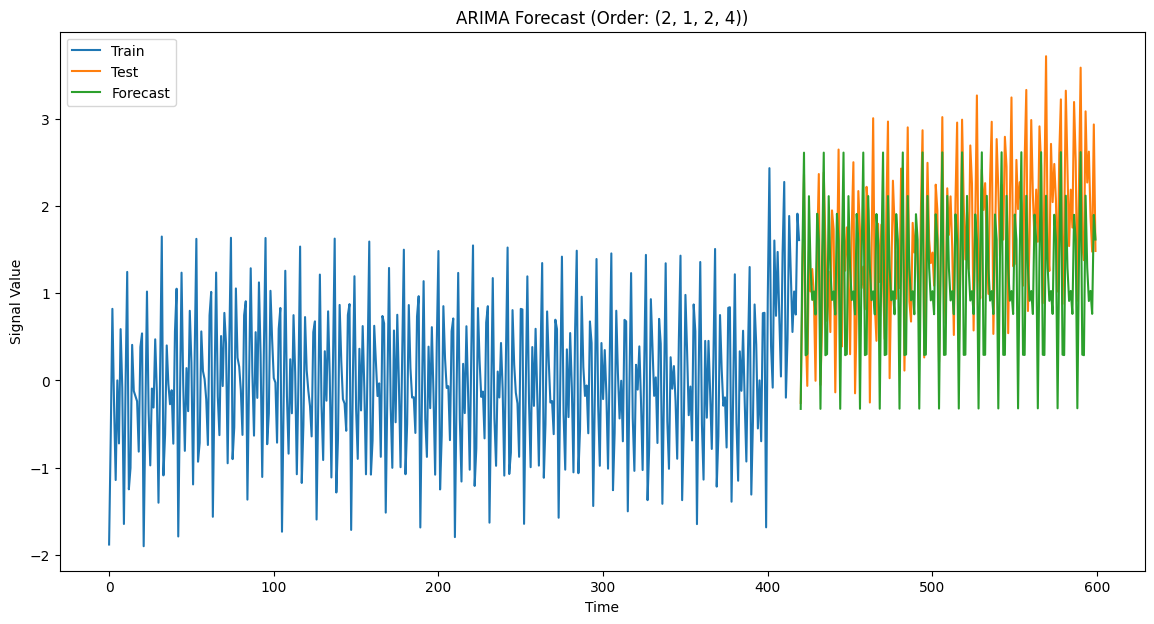

In [39]:
# Apply ARIMA
arima_order = (2, 1, 2, 4)
model = ARIMA(train_data, seasonal_order=arima_order)
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test_data))

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mae = mean_absolute_error(test_data, forecast)
print(f'ARIMA - RMSE: {rmse}, MAE: {mae}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(range(len(train_data)), train_data, label='Train')
plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test')
plt.plot(range(len(train_data), len(train_data) + len(test_data)), forecast, label='Forecast')
plt.title(f'ARIMA Forecast (Order: {arima_order})')
plt.xlabel('Time')
plt.ylabel('Signal Value')
plt.legend()
plt.show()

13:01:14 - cmdstanpy - INFO - Chain [1] start processing
13:01:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet - RMSE: 7722991703570.983, MAE: 6697564185268.918


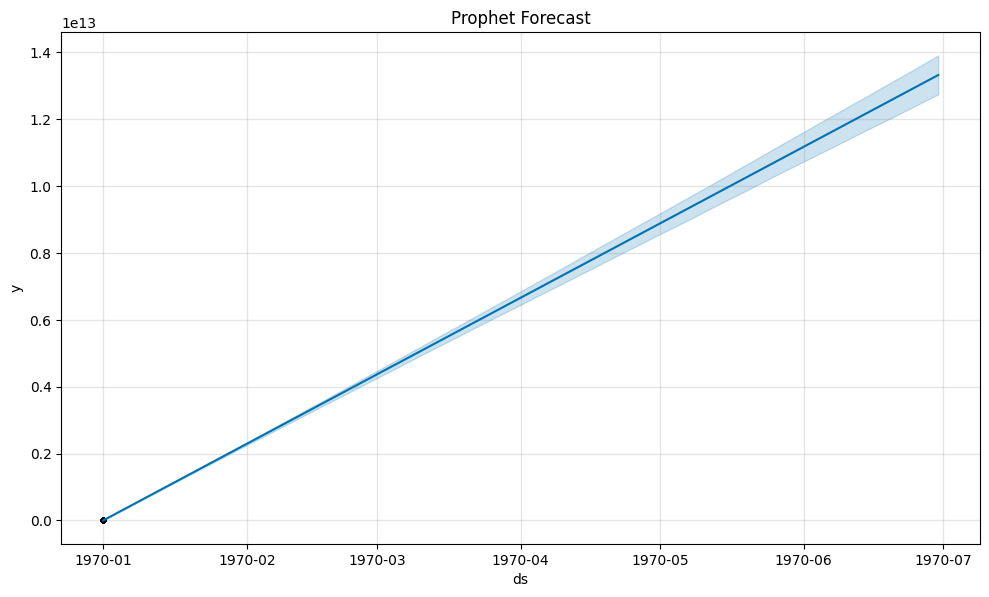

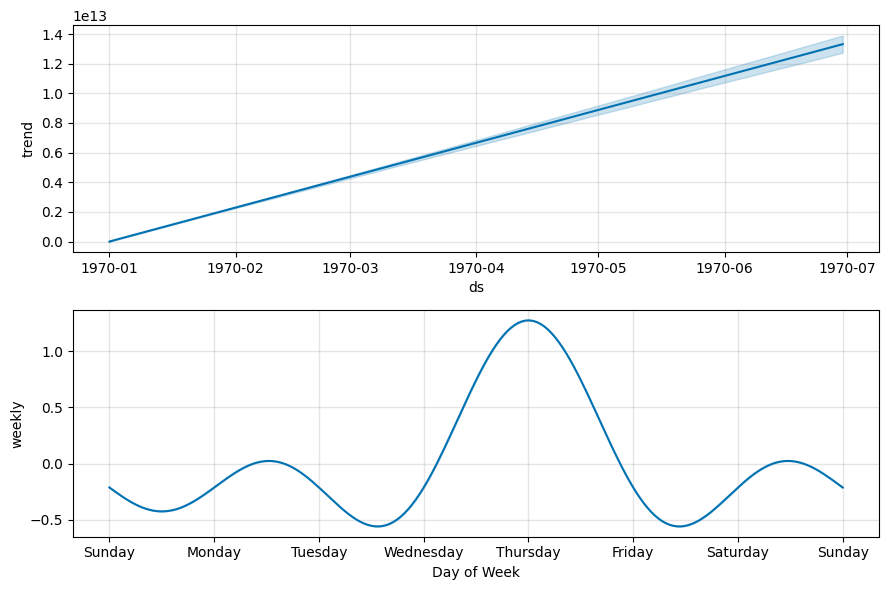

In [40]:
# Prepare the data for Prophet
df_prophet = pd.DataFrame({'ds': t, 'y': pts})
train_data_prophet, test_data_prophet = train_test_split(df_prophet, test_size=0.3, shuffle=False)

# Train the Prophet model
model = Prophet(weekly_seasonality=True, seasonality_mode='additive', interval_width=0.95)
model.fit(train_data_prophet)

# Make predictions
future = model.make_future_dataframe(periods=len(test_data_prophet))
forecast = model.predict(future)

# Calculate RMSE and MAE
forecast_test = forecast.iloc[-len(test_data_prophet):]
rmse = np.sqrt(mean_squared_error(test_data_prophet['y'], forecast_test['yhat']))
mae = mean_absolute_error(test_data_prophet['y'], forecast_test['yhat'])
print(f'Prophet - RMSE: {rmse}, MAE: {mae}')

# Plot the forecast
fig1 = model.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

# Plot the forecast components
fig2 = model.plot_components(forecast)
plt.show()